#Library Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin


#Importing dataset

In [ ]:
df = pd.read_csv("11-avocado_ripeness_dataset.csv")

# Display basic info

In [ ]:
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   firmness        250 non-null    float64
 1   hue             250 non-null    int64  
 2   saturation      250 non-null    int64  
 3   brightness      250 non-null    int64  
 4   color_category  250 non-null    object 
 5   sound_db        250 non-null    int64  
 6   weight_g        250 non-null    int64  
 7   size_cm3        250 non-null    int64  
 8   ripeness        250 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 17.7+ KB


#Checking for Null Values

In [ ]:
df.isnull().sum()


,0
firmness,0
hue,0
saturation,0
brightness,0
color_category,0
sound_db,0
weight_g,0
size_cm3,0
ripeness,0


# Target Class distribution (very balanced)

In [ ]:
print("\nRipeness distribution:")
df['ripeness'].value_counts()



Ripeness distribution:


,count
ripeness,
ripe,50
pre-conditioned,50
hard,50
breaking,50
firm-ripe,50


In [ ]:
print("\nColor category distribution:")
print(df['color_category'].value_counts())


Color category distribution:
color_category
black         75
purple        75
green         50
dark green    50
Name: count, dtype: int64


# Boxplots

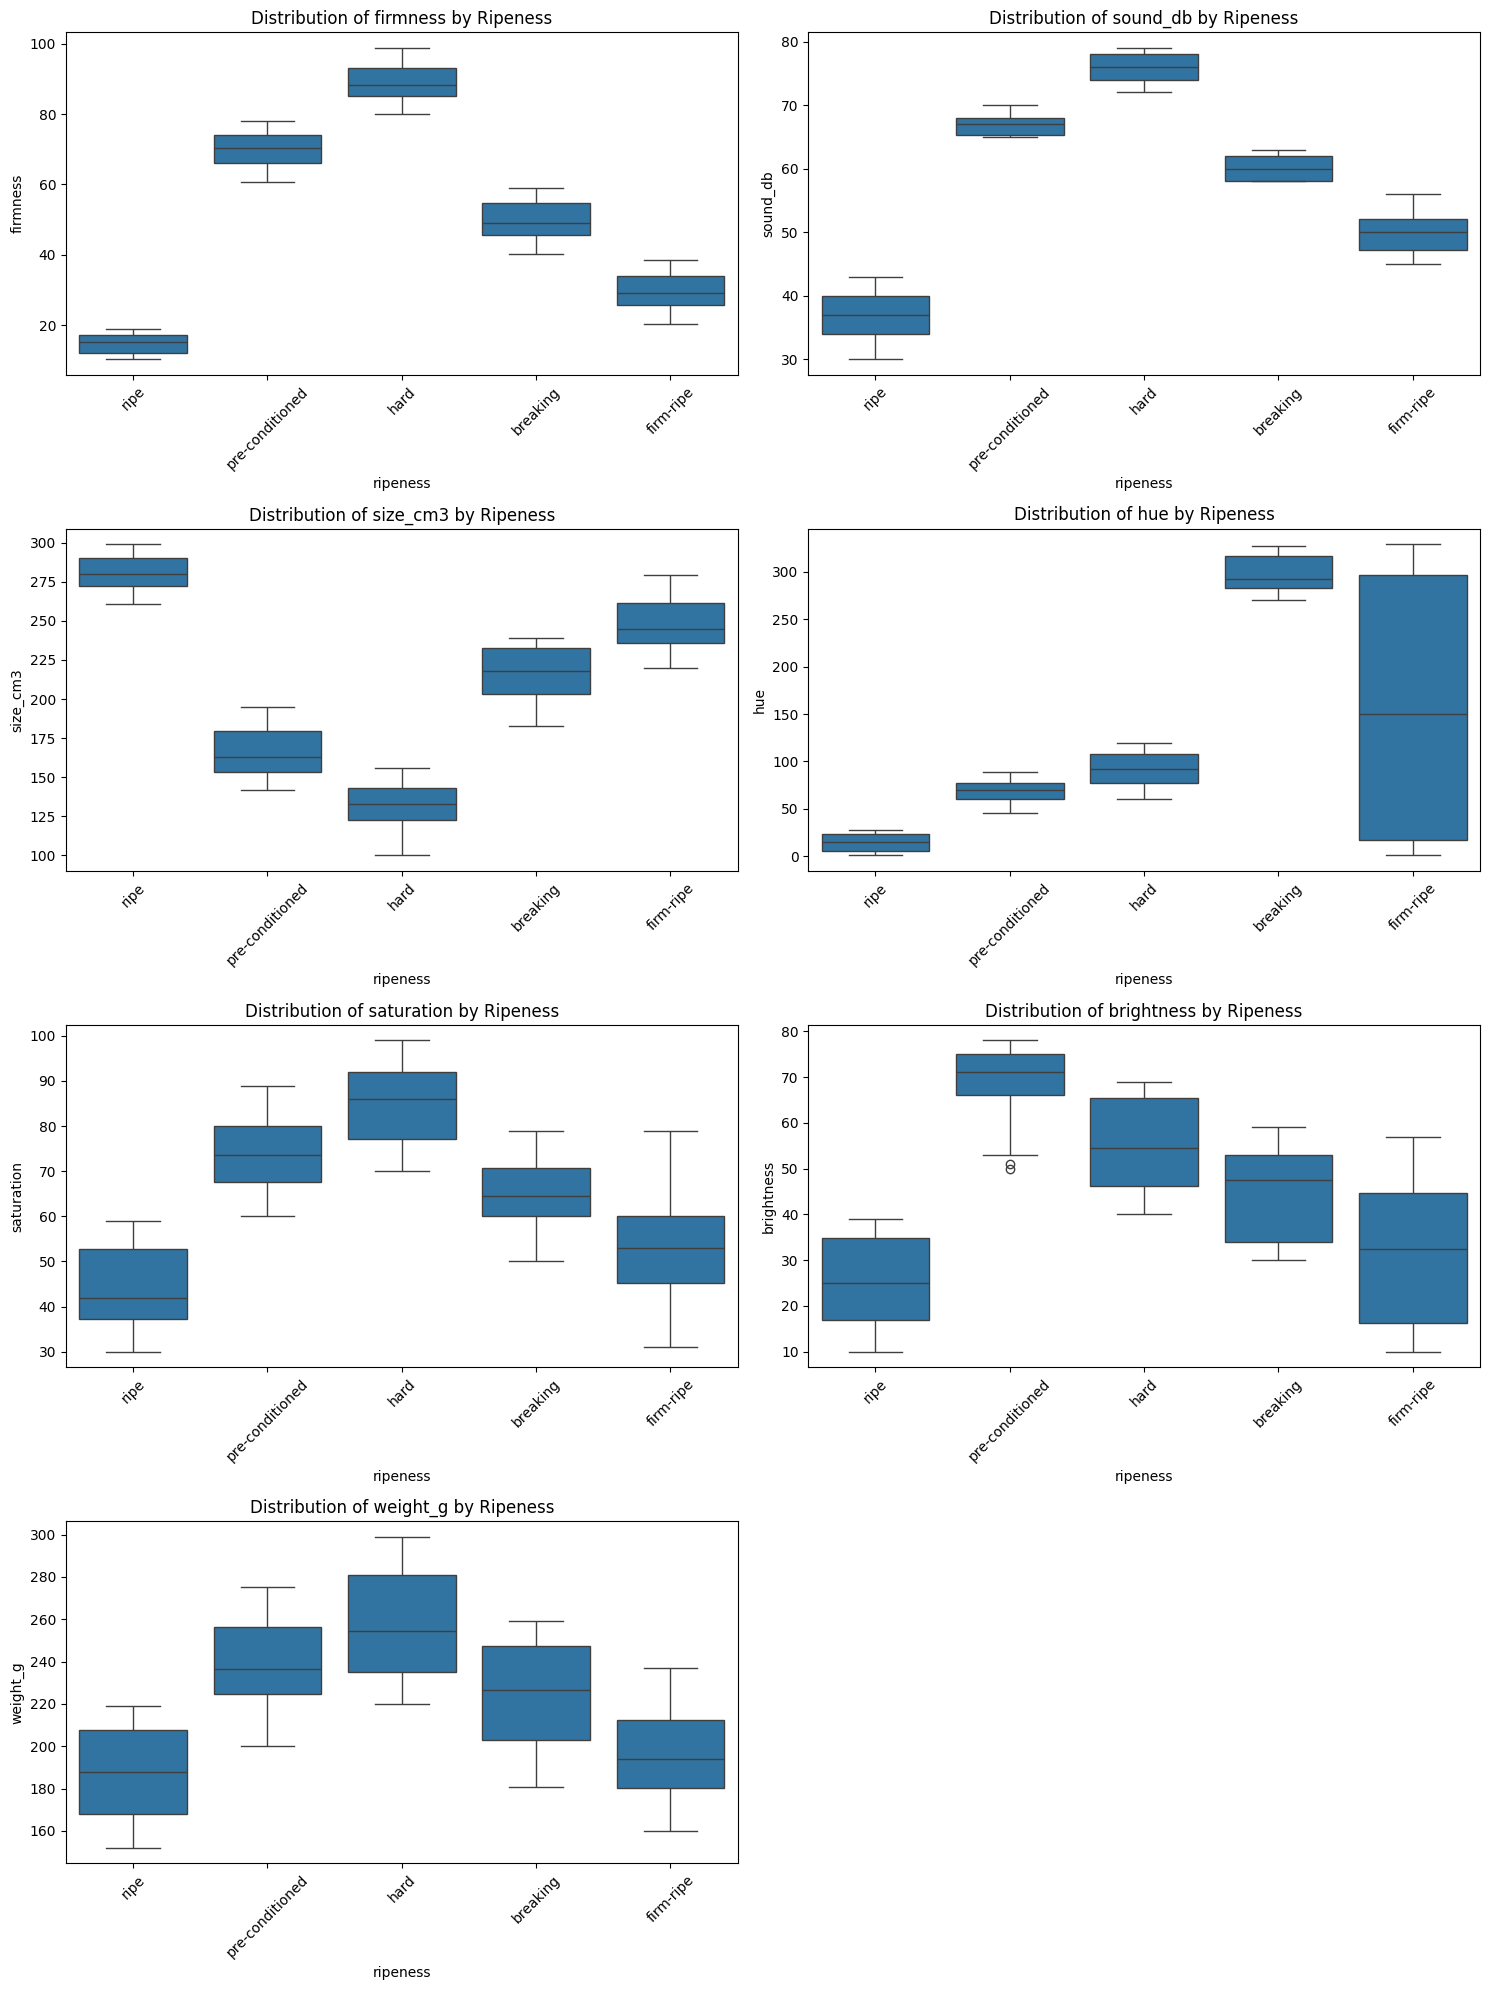

In [ ]:
numeric_columns = ['firmness', 'sound_db','size_cm3','hue', 'saturation', 'brightness',  'weight_g']
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='ripeness', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Ripeness')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avocado_features_boxplot.png')
plt.show()

/tmp/ipython-input-252-1834348953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')
/tmp/ipython-input-252-1834348953.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


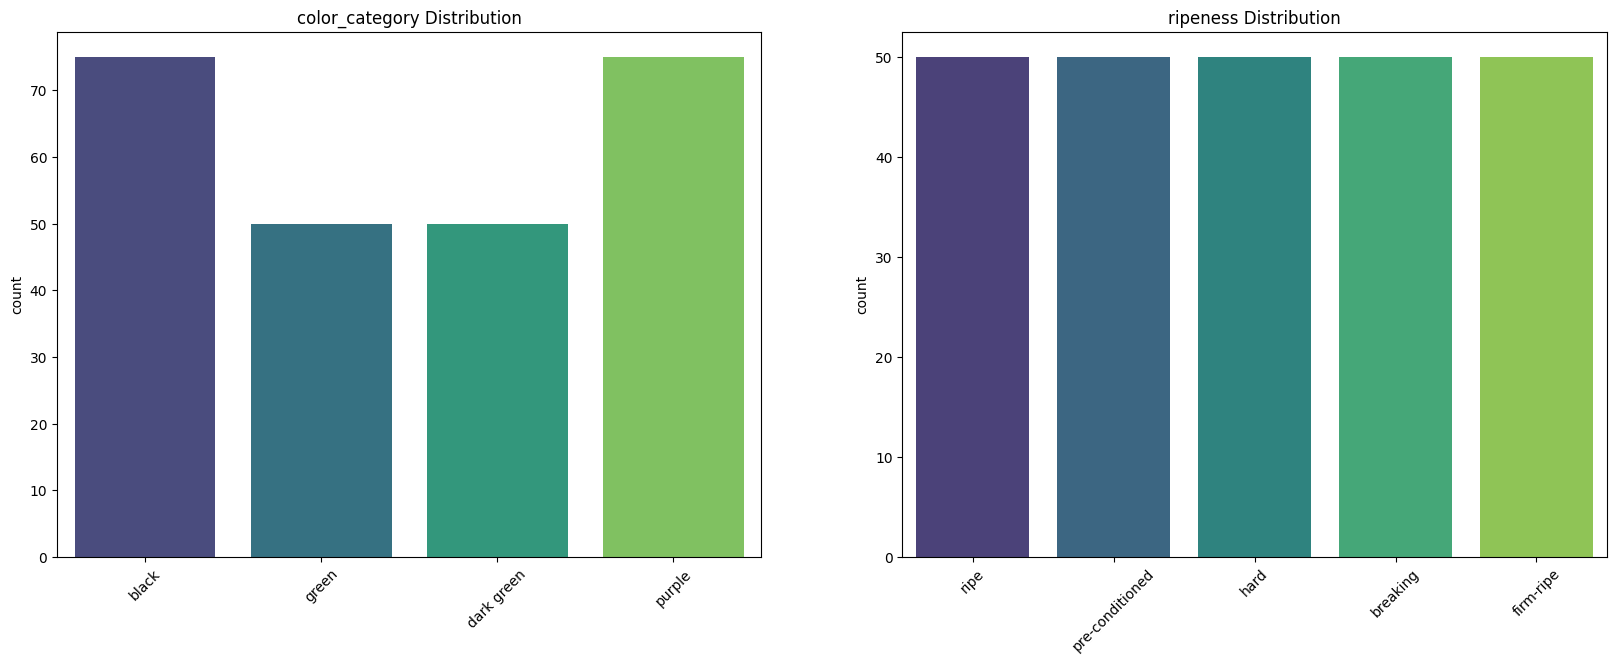

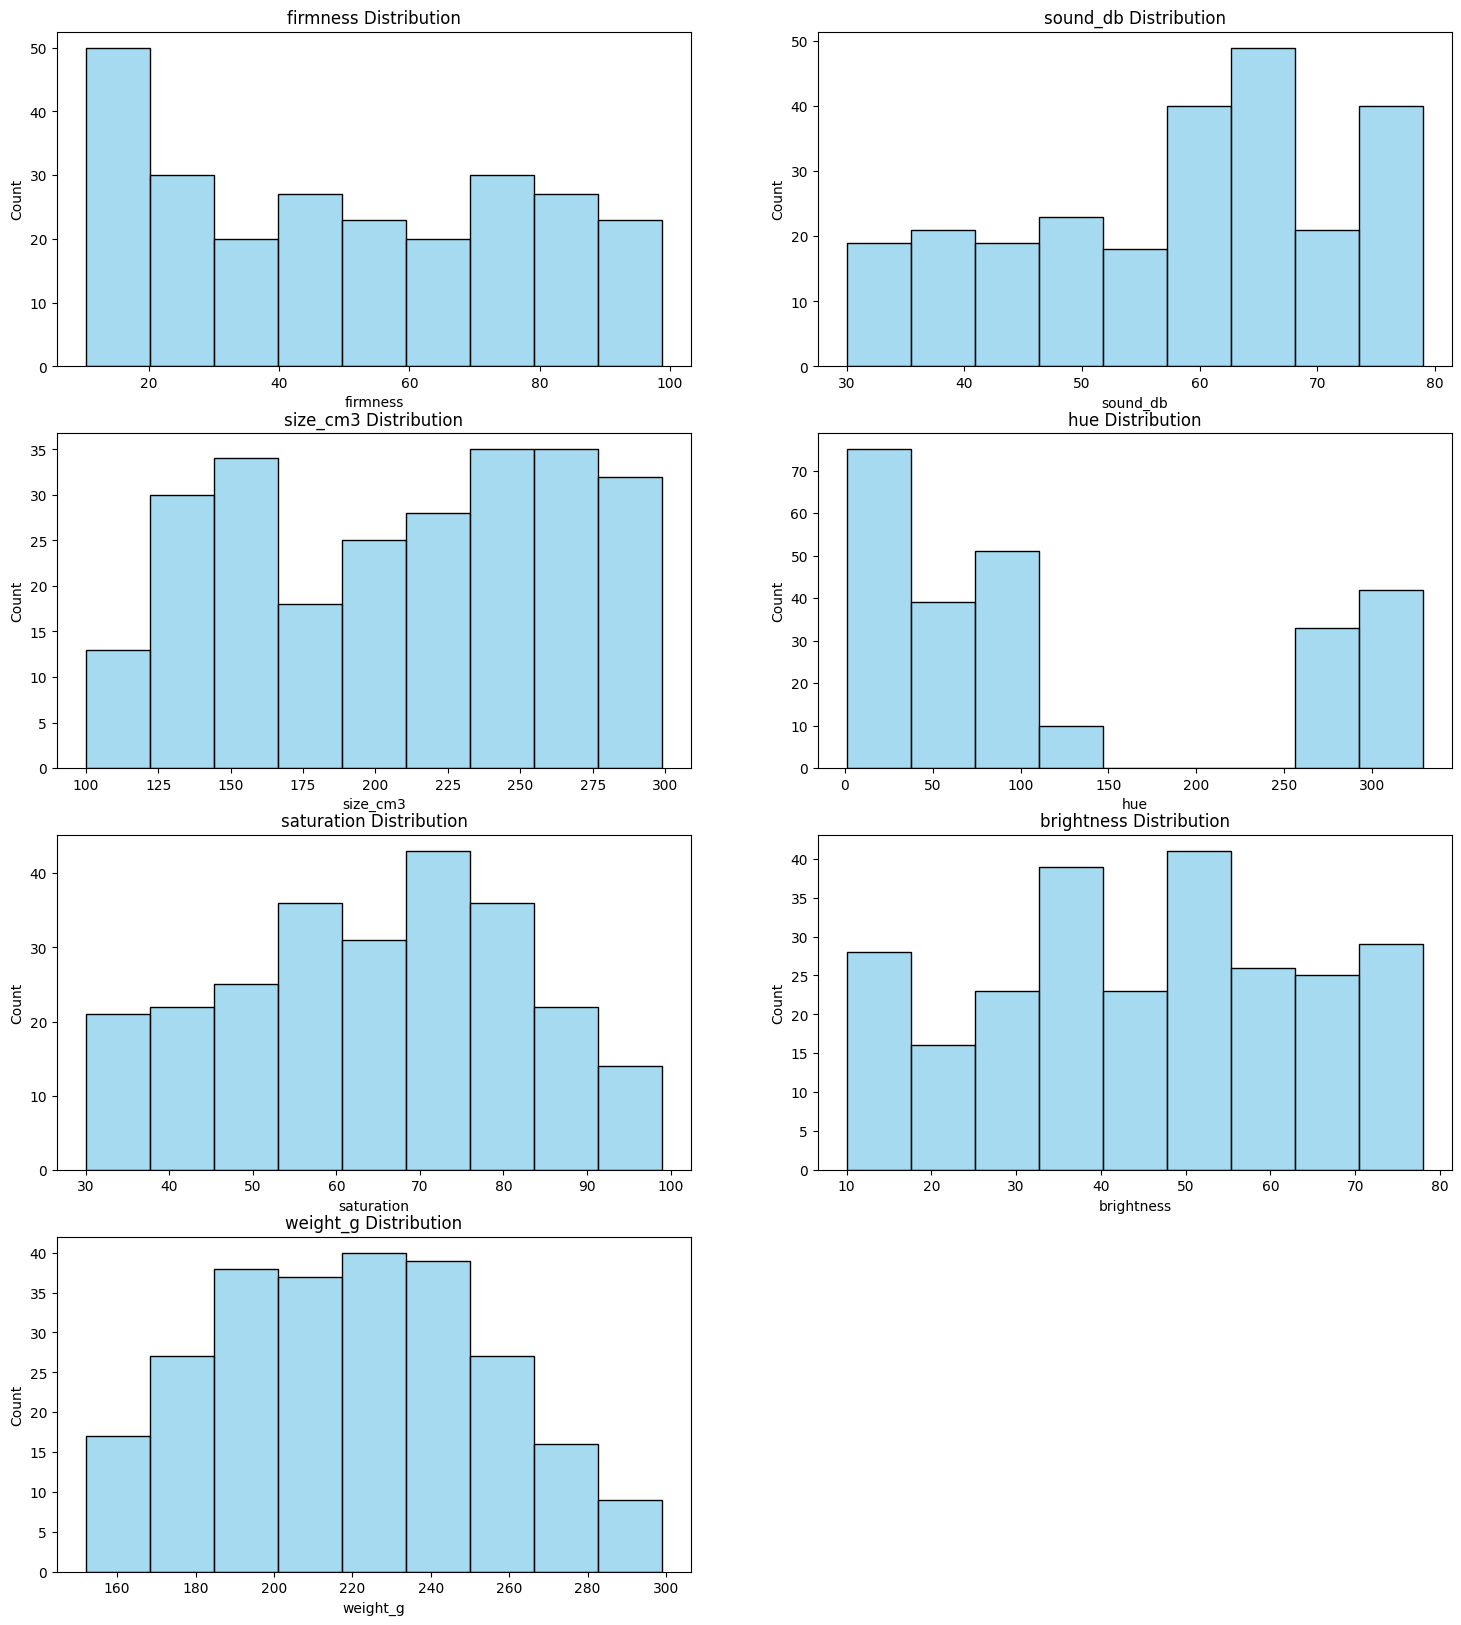

In [ ]:
categorical_cols = ['color_category', 'ripeness']
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
    plt.xlabel('')



plt.figure(figsize=(18, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col],color='skyblue')
    plt.title(f'{col} Distribution')

plt.savefig('feature_distributions.png')
plt.show()

# Encode target variable first


In [ ]:
le = LabelEncoder()
y = le.fit_transform(df['ripeness'])

# Define features (excluding target)


In [ ]:
# X = df.drop(columns=["ripeness"])
X = df.drop(columns=["ripeness","brightness"])


In [ ]:
X

,firmness,hue,saturation,color_category,sound_db,weight_g,size_cm3
0,14.5,19,40,black,34,175,261
1,71.7,53,69,green,69,206,185
2,88.5,60,94,dark green,79,220,143
3,93.8,105,87,dark green,75,299,140
4,42.5,303,58,purple,63,200,227
...,...,...,...,...,...,...,...
245,94.1,83,80,dark green,72,254,134
246,21.6,17,36,black,47,182,240
247,14.0,4,40,black,37,188,274
248,61.5,63,87,green,65,261,162


# Split data FIRST to prevent data leakage


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
X_train

,firmness,hue,saturation,color_category,sound_db,weight_g,size_cm3
139,20.4,22,46,black,52,173,228
182,46.6,288,70,purple,62,221,201
244,98.8,77,95,dark green,77,281,135
105,29.5,20,39,black,49,193,236
90,28.1,25,51,black,56,179,268
...,...,...,...,...,...,...,...
245,94.1,83,80,dark green,72,254,134
119,53.7,318,79,purple,59,241,236
56,73.2,70,76,green,69,242,193
62,17.3,16,53,black,38,162,284


# Identify feature types


In [ ]:
numeric_features = ['firmness', 'hue', 'saturation', 'sound_db', 'weight_g','size_cm3']

# numeric_features = ['firmness', 'hue', 'saturation', 'sound_db', 'weight_g', 'brightness','size_cm3']
categorical_features = ['color_category']

# Feature importance analysis

In [ ]:
X_alt = X_train.copy()
X_alt["color_category"] = LabelEncoder().fit_transform(X_alt["color_category"])

# Calculate Anova. F-statistics

In [ ]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_alt, y_train)

SelectKBest(k='all')

In [ ]:

feature_scores = pd.DataFrame({
    "Feature": X_alt.columns,
    "F_Score": selector.scores_,

}).sort_values("F_Score", ascending=False)


In [ ]:
print("\nFeature Ranking by F-Score:")
print(feature_scores.round(2))


Feature Ranking by F-Score:
          Feature  F_Score
0        firmness  1536.43
4        sound_db  1207.46
6        size_cm3   562.15
1             hue   111.56
3  color_category   108.70
2      saturation    99.30
5        weight_g    60.86


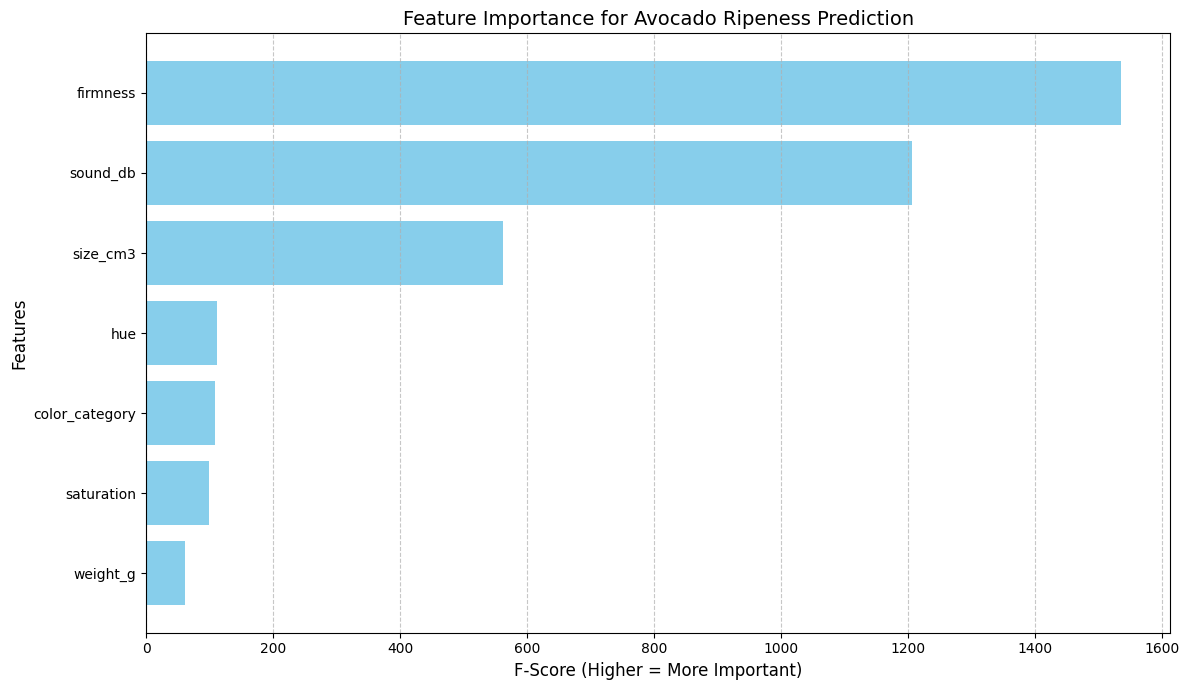

In [ ]:
plt.figure(figsize=(12, 7))
plt.barh(feature_scores['Feature'], feature_scores['F_Score'], color='skyblue')
plt.xlabel('F-Score (Higher = More Important)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for Avocado Ripeness Prediction', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#processing pipeline

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'),categorical_features)
        # ('cat', OneHotEncoder(handle_unknown='ignore'),categorical_features)

    ]
)

# Model Training

In [ ]:
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    "KNN": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])
}

#Evaluate models


--------------------------------------------------
TRAINING LOGISTIC REGRESSION
--------------------------------------------------
CV Mean: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



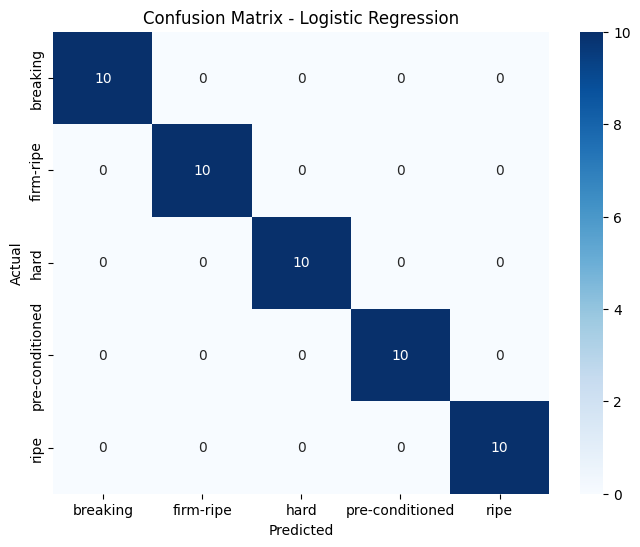


--------------------------------------------------
TRAINING DECISION TREE
--------------------------------------------------
CV Mean: 1.0000 (+/- 0.0000)
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



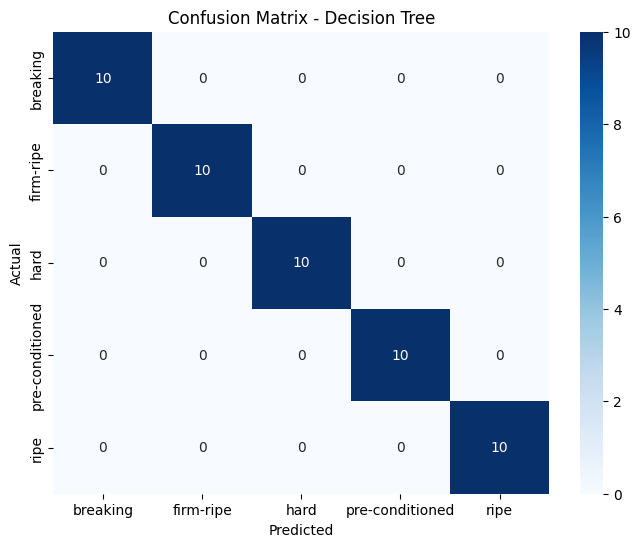


--------------------------------------------------
TRAINING KNN
--------------------------------------------------
CV Mean: 0.9950 (+/- 0.0200)
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



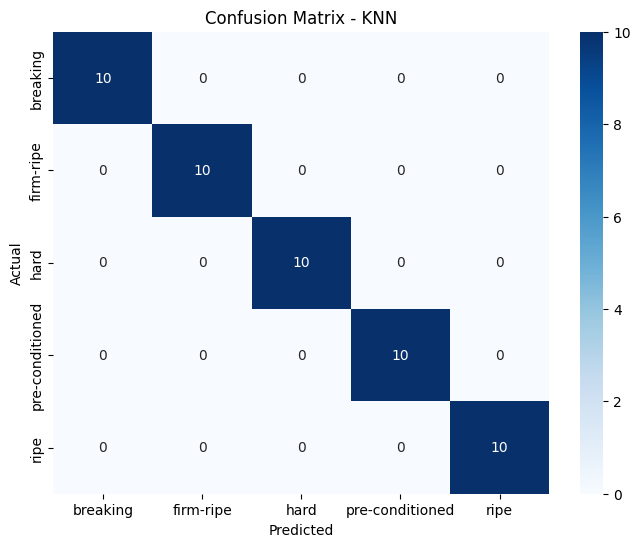

In [ ]:
# results = {}
# for name, model in models.items():
#     print(f"\n{'-'*50}")
#     print(f"TRAINING {name.upper()}")
#     print(f"{'-'*50}")

#     # Train model
#     model.fit(X_train, y_train)

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate
#     accuracy = accuracy_score(y_test, y_pred)
#     results[name] = accuracy

#     print(f"Accuracy: {accuracy:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred))

#     # Confusion matrix
#     conf_matrix = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=le.classes_, yticklabels=le.classes_)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title(f'Confusion Matrix - {name}')
#     plt.show()
results = {}
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"TRAINING {name.upper()}")
    print(f"{'-'*50}")


    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Hyperparameter tuning for KNN

In [ ]:

print("\n" + "="*50)
print("KNN HYPERPARAMETER TUNING")
print("="*50)

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 19],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


KNN HYPERPARAMETER TUNING
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best cross-validation score: 1.0000


In [ ]:
# Evaluate best model
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)

print("\n" + "="*50)
print("BEST KNN MODEL RESULTS")
print("="*50)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


BEST KNN MODEL RESULTS
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0000 (+/- 0.0000)


In [ ]:
# Final results comparison
print("\n" + "="*50)
print("FINAL MODEL COMPARISON")
print("="*50)
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")
print(f"Tuned KNN: {accuracy_score(y_test, y_pred_best):.4f}")


FINAL MODEL COMPARISON
Logistic Regression: 1.0000
Decision Tree: 1.0000
KNN: 1.0000
Tuned KNN: 1.0000
